In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
source_pixels = (
        np.dstack(np.meshgrid(np.arange(5), np.arange(2)))
        .reshape(-1, 2)
        .T
    )

print(source_pixels)

[[0 1 2 3 4 0 1 2 3 4]
 [0 0 0 0 0 1 1 1 1 1]]


In [5]:
destination_pixels = (
        np.dstack(
            np.meshgrid(
                np.arange(5, 7 + 1),
                np.arange(2, 3 + 1),
            )
        )
        .reshape(-1, 2)
        .T
    )
destination_pixels = np.vstack(
        [destination_pixels, np.ones((1, destination_pixels.shape[1]))]
    ).astype(np.int32)

print(destination_pixels)

[[5 6 7 5 6 7]
 [2 2 2 3 3 3]
 [1 1 1 1 1 1]]


In [10]:
def projective_transform(source, H):
    inverse_H = np.linalg.inv(H)
    source_pixels = (
        np.dstack(np.meshgrid(np.arange(source.shape[1]), np.arange(source.shape[0])))
        .reshape(-1, 2)
        .T
    )
    # source pixels in homogeneous coordinates
    source_pixels = np.vstack((source_pixels, np.ones((1, source_pixels.shape[1]))))

    part_of_destination_points = H @ source_pixels
    part_of_destination_points = (
        part_of_destination_points / part_of_destination_points[2, :]
    )

    destination_begining = np.floor(np.min(part_of_destination_points, axis=1))[
        :2
    ].astype(int)
    destination_begining[0], destination_begining[1] = (
        destination_begining[1],
        destination_begining[0],
    )
    destination_end = np.ceil(np.max(part_of_destination_points, axis=1))[:2].astype(
        int
    )
    destination_end[0], destination_end[1] = destination_end[1], destination_end[0]

    destination_img_shape = np.array(
        list(destination_end - destination_begining + 1) + [3]
    )
    destination_pixels = (
        np.dstack(
            np.meshgrid(
                np.arange(destination_begining[1], destination_end[1] + 1),
                np.arange(destination_begining[0], destination_end[0] + 1),
            )
        )
        .reshape(-1, 2)
        .T
    )
    destination_pixels = np.vstack(
        [destination_pixels, np.ones((1, destination_pixels.shape[1]))]
    ).astype(np.int32)

    destination_img = np.zeros(destination_img_shape, dtype=np.uint8)

    source_pixels = source_pixels[:2].astype(int)
    part_of_destination_points = part_of_destination_points[:2]

    mask = np.ones(destination_img_shape[:2], dtype=np.bool_)

    # more robust version with using inverse transformation and 1nn
    for dp in destination_pixels.T:
        sp = inverse_H @ dp
        sp = sp / sp[2]
        sp = sp[:2]
        sp = get_1nn_pixel(sp)

        dimg_index = (dp[0] - destination_begining[1], dp[1] - destination_begining[0])
        if (
            sp[0] < 0
            or sp[0] >= source.shape[1]
            or sp[1] < 0
            or sp[1] >= source.shape[0]
        ):
            mask[dimg_index[1], dimg_index[0]] = 0
        else:
            destination_img[dimg_index[1], dimg_index[0]] = source[sp[1], sp[0]]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(source, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis("on")
    axes[1].imshow(cv2.cvtColor(destination_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Transformed Image")
    axes[1].axis("on")
    plt.show()

    return destination_img

def get_1nn_pixel(approximate_pixel_coordinates):
    # the np.round() rounds to a nearest pixel_coordinates in L1 norm
    return np.round(approximate_pixel_coordinates).astype(int)

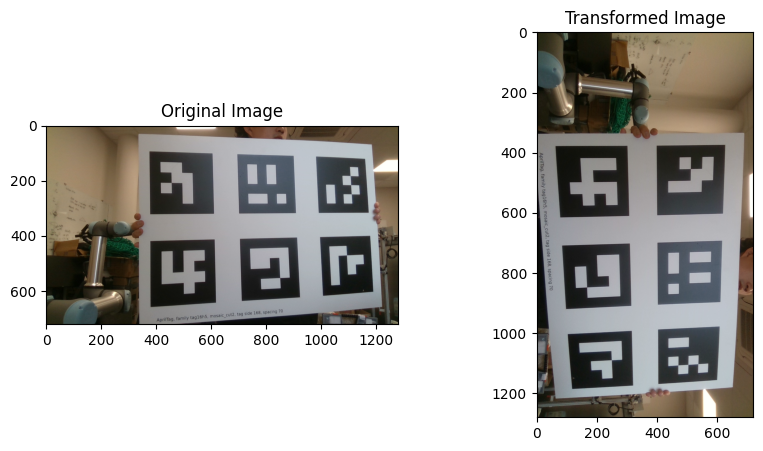

In [16]:
H = np.array([[0, -1, 35], [1, 0, 35], [0, 0, 1]])
img = cv2.imread("calibration\img1.png")
hej = projective_transform(img, H)

In [9]:
cos = np.arange(17)

print(cos[-5:])

[12 13 14 15 16]
